In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
pd.options.display.max_columns = 100
%matplotlib inline

In [70]:
def transform(df):
    df2 = df.copy()
    #fill na for city data - 395 missing entries - categorical and numerical, for now assume they come from the most frequent town
    df2['commune_code'] = df2['commune_code'].fillna(df2['commune_code'].mode()[0])
    df2['canton_code'] = df2['canton_code'].fillna(df2['canton_code'].mode()[0])
    df2['city_district_code'] = df2['city_district_code'].fillna(df2['city_district_code'].mode()[0])
    df2['regional_department_code'] = df2['regional_department_code'].fillna(df2['regional_department_code'].mode()[0])
    df2['population'] = df2['population'].fillna(df2['population'].mode()[0])
    df2['town_mean_altitude'] = df2['town_mean_altitude'].fillna(df2['town_mean_altitude'].mode()[0])
    df2['town_surface_area'] = df2['town_surface_area'].fillna(df2['town_surface_area'].mode()[0])
    
#     #impute or remove illogical values
    df2.loc[df2['vh_weight']==0,'vh_weight'] = df2['vh_weight'].median() # - 2959 missing entries - imputation doesnt give a better correlation
    df2 = df2.loc[df2['drv_age1']>=df2['drv_age_lic1']] # 32 missing entires; dropped
    df2 = df2.loc[df2['vh_cyl']>0] #3 missing entries
    df2.loc[df2['vh_value']==0,'vh_value'] = 18659 #from data exploration

#     #one hot encode categorical features; 
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_coverage'])],axis=1)
    df2.loc[df2['pol_usage']=='AllTrips','pol_usage'] = 'Professional' #- only 77 AllTrips; from data description it is similar to professional
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_usage'])],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_pay_freq'])],axis=1)

#     #binarize features
    df2['pol_payd'] = (df2['pol_payd'] == 'Yes') * 1 # Yes/ No
    df2['drv_drv2'] = (df2['drv_drv2'] == 'Yes') * 1 # Yes / No
    df2['tourism'] = (df2['vh_type'] == 'Tourism') * 1 #tourism or commerical
    df2['diesel'] = (df2['vh_fuel'] == 'Diesel') * 1 #also hybrids but very low representation - 62 hybrids
    df2['M'] = (df2['drv_sex1'] == 'M') * 1 #Male / Female
    
#     df2['pol_bonus2'] = (df2['pol_bonus'] == 0.5) * 1
    
    
#     #ordinally encode policy coverage
    order = {'Mini':1,'Median2':2,'Median1':3,'Maxi':4}
    df2['order_pol_coverage'] = df['pol_coverage'].apply(lambda x : order[x])

    unwantedFeatures= ['id_policy','pol_coverage','pol_pay_freq','pol_usage','pol_insee_code','drv_sex1',
                   'drv_age2','drv_sex2','drv_age_lic2','vh_fuel','vh_make','vh_model','vh_type']+['commune_code',
       'canton_code', 'city_district_code', 'regional_department_code']+['Yearly']+['made_claim','claim_amount']#+['drv_drv2']
    
    y1 = df2['made_claim']
    y2 = df2['claim_amount']
    df2 = df2.drop(unwantedFeatures,axis=1)
    return y1, y2, df2



df = pd.read_csv("training_data.csv")
y1, y2, df2 = transform(df)
df2.head()

,pol_bonus,pol_duration,pol_sit_duration,pol_payd,drv_drv2,drv_age1,drv_age_lic1,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,Maxi,Median1,Median2,Mini,Professional,Retired,WorkPrivate,Biannual,Monthly,Quarterly,tourism,diesel,M,order_pol_coverage
0,0.5,36,6,0,0,77,55,15,1598,111,16,15,185,17517,1260.0,526.0,3216.0,4.8,1,0,0,0,0,1,0,1,0,0,1,0,1,4
1,0.5,15,5,0,1,52,33,12,2184,112,12,9,180,21500,1480.0,57.0,4912.0,141.3,1,0,0,0,0,0,1,0,0,0,1,1,1,4
2,0.5,16,6,0,0,52,34,20,2496,112,32,19,130,23600,2931.0,257.0,4488.0,5.3,0,0,0,1,1,0,0,0,1,0,0,1,1,1
3,0.5,11,7,0,0,67,46,12,1149,75,14,12,170,13050,930.0,109.0,1339.0,61.2,1,0,0,0,0,0,1,1,0,0,1,0,1,4
4,0.5,16,6,0,1,60,35,23,1905,93,23,18,185,17974,1035.0,24.0,1849.0,9.7,0,0,1,0,0,0,1,1,0,0,1,1,1,2


In [72]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, roc_auc_score,roc_curve,mean_squared_error,plot_precision_recall_curve
from sklearn.model_selection import cross_val_score,train_test_split,learning_curve
booleanFeatures = ['pol_payd','Professional','WorkPrivate','M','diesel','order_pol_coverage','tourism']#+['Retired','Maxi', 'Median1', 'Median2', 'Mini'] # omitted - + ['drv_drv2','vh_make','vh_model','canton_code','commune_code',city_district_code','regional_department_code','Biannual', 'Monthly','Quarterly']
numericFeatures = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'vh_sale_begin', 'vh_sale_end', 'vh_cyl', 'vh_speed', 'drv_age1', 'vh_weight', 'vh_age', 'drv_age_lic1'] #+ ['order_pol_coverage','town_surface_area','town_mean_altitude']
X4 = df2[numericFeatures+booleanFeatures].copy()

In [73]:
#denoise vehicle age factors;
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures


#Normalised features
df3 = df2.copy()
df3[numericFeatures] = ((df3[numericFeatures]-df3[numericFeatures].mean())/df3[numericFeatures].std())
df3['order_pol_coverage']/=4

#transformations
df4 = df2.copy()
df4['population'] = np.log(df4['population']+1)
df4['vh_din'] = np.log(df4['vh_din'])
df4['vh_value'] = np.log(df4['vh_value'])
df4['vh_weight'] = np.log(df4['vh_weight'])
df4['vh_age'] = np.log(df4['vh_age'])
df4['vh_sale_begin'] = np.log(df4['vh_sale_begin'])
df4[numericFeatures] = ((df4[numericFeatures]-df4[numericFeatures].mean())/df4[numericFeatures].std())
df4['order_pol_coverage']/=4

    
    
    
#PCA transformed
pca = PCA()
X2 = pca.fit_transform(df3[numericFeatures])[:,:12]
X3 = pd.concat([df3[booleanFeatures].copy(),pd.DataFrame(X2,index=df3[booleanFeatures].index)],axis=1)

#polynomial features
X4 = df3[numericFeatures+booleanFeatures].copy()
# feats = list(X4.columns)
# for i in range(len(numericFeatures)):
#     for j in range(i+1,len(numericFeatures+booleanFeatures)):
#         X4[feats[i]+"_and_"+feats[j]] = X4[feats[i]] * X4[feats[j]]
poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
X5 = pd.DataFrame(poly.fit_transform(X4),index=X4.index)

In [5]:
def diagnosis(y1,preds):
    ax = sns.heatmap(confusion_matrix(y1,np.round(preds)),cmap = "coolwarm", annot = True,fmt="d", linewidths = 0.5)
    ax.set_title("Confusion Matrix")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    print("MSE %f"%(mean_squared_error(y1,preds)))
    print("F1 Score: %f"%(f1_score(y1,np.round(preds))))
    print(classification_report(y1,np.round(preds)))
    
def plot_learning_curve(train_sizes,train_scores,test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    fig, axes = plt.subplots(figsize=(20,3))

    axes.set_title("Learning Curve")
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
    axes.legend(loc="best")

In [58]:
y3 = y2[y1==1]
X5 = X5.loc[y3.index]

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Dropout
from sklearn.model_selection import train_test_split

In [8]:


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


In [74]:
# sgd = tf.keras.optimizers.SGD(learning_rate=1e-3)
adam = tf.keras.optimizers.Adam()
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.1)
pos = (y1==1).sum()
neg = (y1==0).sum()
initial_bias = np.log([pos/neg])

input_data = Input(shape=(X4.shape[1],))

# d = Dense(16,activation='relu')(c)
# e = Dense(16,activation='relu')(d)
# c = Dropout(0.5)(b)
# b = Dense(units=1,
#           activation='sigmoid',
#           bias_initializer=tf.keras.initializers.Constant(value=initial_bias),        
#          )(input_data)
# c = Dense(units=1,activation='sigmoid')(b)
# d = Dense(units=1,activation='sigmoid')(c)
# e = Dense(units=1,activation='sigmoid')(d)
output = Dense(units=1,activation='sigmoid')(input_data)
# output = Dense(units=1,activation='sigmoid')(b)

model = Model(inputs=input_data,outputs=output)


model.compile(optimizer=adam,loss='binary_crossentropy',metrics=METRICS)
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 21)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 22        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [75]:
EPOCHS = 100
BATCH_SIZE = 2048

import datetime

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)


# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = tf.keras.callbacks.History()


X_train, X_test,y_train,y_test = train_test_split(X4,y1,test_size=0.3,stratify=y1,shuffle=True)
results = model.fit(X_train,y_train,
                    class_weight={0:1,1:8},
                    validation_data=(X_test,y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                   callbacks=[early_stopping,history])

MSE 0.199722
F1 Score: 0.215690
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     21638
           1       0.14      0.49      0.22      2178

    accuracy                           0.67     23816
   macro avg       0.53      0.59      0.50     23816
weighted avg       0.86      0.67      0.74     23816



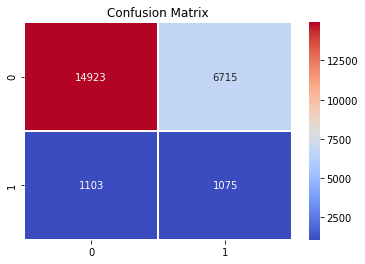

In [76]:
diagnosis(y_test,model.predict(X_test))

MSE 0.200153
F1 Score: 0.218193
              precision    recall  f1-score   support

           0       0.93      0.68      0.79     50487
           1       0.14      0.51      0.22      5082

    accuracy                           0.67     55569
   macro avg       0.54      0.60      0.50     55569
weighted avg       0.86      0.67      0.74     55569



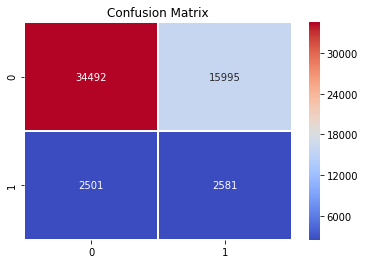

In [77]:
diagnosis(y_train,model.predict(X_train))

MSE 0.200024
F1 Score: 0.217451
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     72125
           1       0.14      0.50      0.22      7260

    accuracy                           0.67     79385
   macro avg       0.54      0.59      0.50     79385
weighted avg       0.86      0.67      0.74     79385



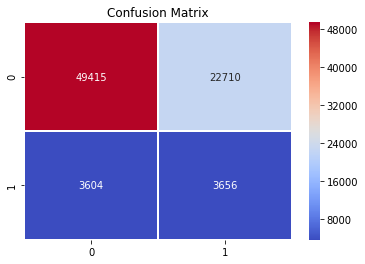

In [78]:
diagnosis(y1,model.predict(X4))

<BarContainer object of 21 artists>

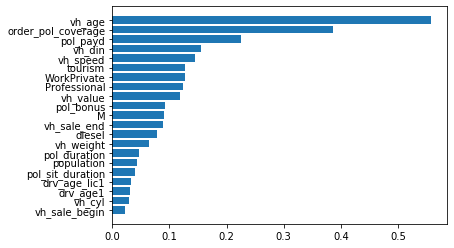

In [79]:
featImportances = dict(sorted(zip(list(X4.columns),model.layers[1].get_weights()[0].reshape(1,-1)[0]),key=lambda k : abs(k[1]),reverse=False))
plt.barh(list(featImportances.keys()),[abs(x) for x in featImportances.values()])

In [113]:
import tensorflow as tf
from tensorflow.keras.losses import Huber,MeanSquaredLogarithmicError
huber = Huber()
a = Input(shape=(X4.shape[1],))
b = Dense(1,activation='linear')(a)

model = Model(inputs=a,outputs=b)
model.compile(optimizer='Adam',loss=MeanSquaredLogarithmicError())
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 22)]              0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 23        
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [114]:
EPOCHS = 100
BATCH_SIZE = 2048

import datetime

early_stopping2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)


# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history2 = tf.keras.callbacks.History()


X_train, X_test,y_train,y_test = train_test_split(X4,y2,test_size=0.5,stratify=y1,shuffle=True)
results = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                   callbacks=[early_stopping2,history2])

Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


In [115]:
model.layers[-1].get_weights()

[array([[ 0.19319867],
        [ 0.08934554],
        [ 0.28100303],
        [-0.20517786],
        [-0.13031916],
        [-0.03696618],
        [-0.05583894],
        [-0.3303552 ],
        [ 0.36836994],
        [-0.26425043],
        [-0.13836688],
        [ 0.13664594],
        [ 0.24458858],
        [ 0.3194755 ],
        [ 0.39205012],
        [-0.19768967],
        [-0.23046753],
        [ 0.4104949 ],
        [ 0.04985841],
        [-0.27113834],
        [ 0.5203064 ],
        [-0.22215074]], dtype=float32), array([0.019679], dtype=float32)]

R2 score: test -0.007219247806896423
R2 score: train -0.036321777913085995
R2 score: whole -0.011262175710697875


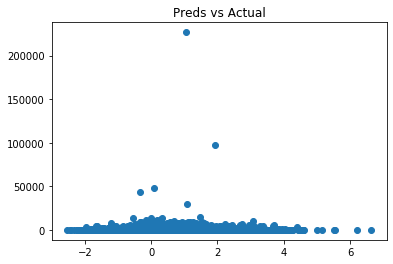

In [116]:
print("R2 score: test",r2_score(y_test,model.predict(X_test)))
print("R2 score: train",r2_score(y_train,model.predict(X_train)))
preds = model.predict(X4)
print("R2 score: whole",r2_score(y2,preds))

fig,axes = plt.subplots()
axes.set_title('Preds vs Actual')
plt.scatter(preds,y2)

In [12]:

%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 37761), started 0:03:41 ago. (Use '!kill 37761' to kill it.)

In [81]:
X4['preds'] = model.predict(X4)

In [168]:

from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
sgd = tf.keras.optimizers.SGD(learning_rate=1e-3)
adam = tf.keras.optimizers.Adam()
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.1)
pos = (y1==1).sum()
neg = (y1==0).sum()
initial_bias = np.log([pos/neg])

latent_dim = 10
intermediate_dim = 24
input_shape = X4.shape[1]
original_dim = X4.shape[1]
# input_data = Input(shape=(X4.shape[1],))
# encoded = Dense(encoding_dim,activation='relu')(input_data)
# decoded = Dense(units=X4.shape[1],activation='linear')(encoded)
# model = Model(inputs=input_data,outputs=decoded)

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='linear')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(inputs, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(inputs, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)



In [169]:
vae.compile(optimizer='adadelta', loss='mean_squared_error')
vae.summary()

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 22)]         0                                            
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 24)           552         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           250         dense_71[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           250         dense_71[0][0]                   
___________________________________________________________________________________________

In [170]:
results = vae.fit(X_train,X_train,shuffle=True,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,X_test),callbacks=[history,early_stopping])

Train on 59538 samples, validate on 19847 samples
Epoch 1/100
59538/59538 [==============================] - 1s 20us/sample - loss: 1.2782 - val_loss: 1.2818
Epoch 2/100
59538/59538 [==============================] - 0s 3us/sample - loss: 1.2793 - val_loss: 1.2849
Epoch 3/100
59538/59538 [==============================] - 0s 3us/sample - loss: 1.2797 - val_loss: 1.2754
Epoch 4/100
59538/59538 [==============================] - 0s 3us/sample - loss: 1.2825 - val_loss: 1.2780
Epoch 5/100
59538/59538 [==============================] - 0s 4us/sample - loss: 1.2791 - val_loss: 1.2726
Epoch 6/100
59538/59538 [==============================] - 0s 4us/sample - loss: 1.2749 - val_loss: 1.2729
Epoch 7/100
59538/59538 [==============================] - 0s 3us/sample - loss: 1.2733 - val_loss: 1.2715
Epoch 8/100
59538/59538 [==============================] - 0s 3us/sample - loss: 1.2701 - val_loss: 1.2736
Epoch 9/100
59538/59538 [==============================] - 0s 3us/sample - loss: 1.2671 - val

In [171]:
x_test_encoded = encoder.predict(X_test, batch_size=BATCH_SIZE)

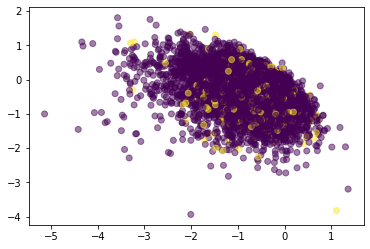

In [172]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,alpha=0.5)

In [173]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(solver='saga',class_weight={0:1,1:9})
logit.fit(x_test_encoded,y_test)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 9}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

MSE 0.222807
F1 Score: 0.198072
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     18040
           1       0.12      0.50      0.20      1807

    accuracy                           0.63     19847
   macro avg       0.53      0.57      0.48     19847
weighted avg       0.85      0.63      0.71     19847



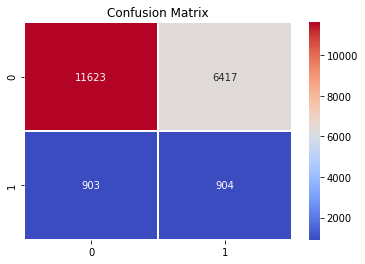

In [174]:
diagnosis(y_test,logit.predict_proba(x_test_encoded)[:,1])

MSE 0.221785
F1 Score: 0.203114
              precision    recall  f1-score   support

           0       0.93      0.65      0.76     54085
           1       0.13      0.51      0.20      5453

    accuracy                           0.64     59538
   macro avg       0.53      0.58      0.48     59538
weighted avg       0.86      0.64      0.71     59538



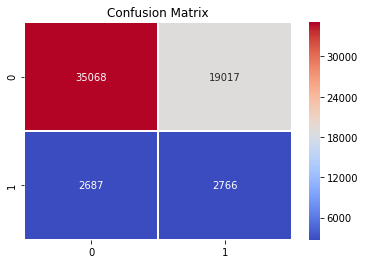

In [175]:
diagnosis(y_train,logit.predict_proba(encoder.predict(X_train))[:,1])

In [107]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X4,y1,test_size=0.25)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)
history = tf.keras.callbacks.History()
results = model.fit(X_train,X_train,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True,verbose=0,callbacks=[early_stopping,history],validation_data=(X_test,X_test))

Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


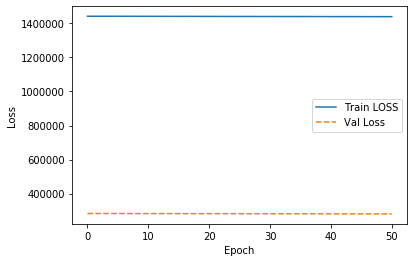

In [99]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history):
  # Use a log scale to show the wide range of values.
    plt.plot(history.epoch,  history.history['loss'],label = 'Train LOSS')
    plt.plot(history.epoch,  history.history['val_loss'],linestyle="--",label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plot_loss(history2)

In [77]:
model.predict(X5).reshape(1,-1)

array([[7.939221 , 8.381655 , 5.8507094, ..., 4.8754563, 9.91482  ,
        5.9532123]], dtype=float32)

In [81]:
pd.Series(np.exp(model.predict(X5).reshape(1,-1)[0])).describe()

count    7.260000e+03
mean     1.709292e+04
std      1.020823e+06
min      2.912950e+00
25%      1.303500e+02
50%      3.613745e+02
75%      1.022758e+03
max      8.495670e+07
dtype: float64

In [102]:
pos = (y1==1).sum()
neg = (y1==0).sum()

In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Dropout

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
          16, activation='relu',
          input_shape=(len(numericFeatures+booleanFeatures),)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

initial_bias = np.log([pos/neg])

model = make_model(output_bias=initial_bias)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16)                368       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [47]:
print(f1_score(y1,np.round(model.predict(X4)[:,0])))
confusion_matrix(y1,np.round(model.predict(X4)))

0.1431969111969112


array([[49328, 22797],
       [ 4942,  2318]])

In [83]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
results[0]

0.5099614966634224

In [97]:

import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)


In [30]:
print(f1_score(y1,np.round(model.predict(df3[numericFeatures+booleanFeatures]))))
confusion_matrix(y1,np.round(model.predict(df3[numericFeatures+booleanFeatures])))

0.0


array([[72125,     0],
       [ 7260,     0]])

0.3247110598207406

In [16]:
from sklearn.metrics import confusion_matrix,f1_score


In [18]:
import tensorflow_probability as tfp

ModuleNotFoundError: No module named 'tensorflow_probability'

# Reading

https://www.kaggle.com/mlg-ulb/creditcardfraud

Oversample positive class
Undersample negative class

In [238]:
y2[y2!=0].quantile([0.9,0.95,0.975,0.9975,1])

0.9000      2468.748000
0.9500      3501.980000
0.9750      4475.830000
0.9975      9371.879325
1.0000    226841.890000
Name: claim_amount, dtype: float64

In [240]:
y2.loc[y2==226841.890000]

64077    226841.89
Name: claim_amount, dtype: float64

In [241]:
df2.loc[64077]

pol_bonus                 0.5
pol_duration             30.0
pol_sit_duration          5.0
pol_payd                  1.0
drv_drv2                  0.0
drv_age1                 71.0
drv_age_lic1             50.0
vh_age                    9.0
vh_cyl                 1360.0
vh_din                   89.0
vh_sale_begin            10.0
vh_sale_end               9.0
vh_speed                173.0
vh_value              15650.0
vh_weight              1215.0
town_mean_altitude      231.0
town_surface_area       492.0
population                5.8
Maxi                      1.0
Median1                   0.0
Median2                   0.0
Mini                      0.0
Professional              0.0
Retired                   1.0
WorkPrivate               0.0
Biannual                  0.0
Monthly                   0.0
Quarterly                 0.0
tourism                   1.0
diesel                    0.0
M                         0.0
pol_bonus2                1.0
order_pol_coverage        4.0
Name: 6407